In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from numpy import linalg as LA
from sklearn.datasets import fetch_rcv1

In [2]:
np.set_printoptions(suppress=True)

In [3]:
rcv1 = fetch_rcv1()

In [4]:
rcv1['data'].shape

(804414, 47236)

In [5]:
feature = rcv1['data'].shape[1]

# Problem 1

In [6]:
# Generate new label, where 'CCAT' is 1, and -1 otherwise.
def newLabel(matrix):
    new_label = []
    row_num = matrix.shape[0]
    for i in range(row_num):
        if matrix[i, 33] == 1:
            new_label.append(1)
        else:
            new_label.append(-1) # set it to 0 and then sum to verify.
    return new_label

In [7]:
label = newLabel(rcv1['target']) # 381327 

In [9]:
def trainTestSplit(data, label, article_num):
    # here data is rcv1['data']
    # label is new label produced above
    # article_num = 100,000
    X_train = data[0 : article_num]
    X_test = data[article_num : ]
    y_train = label[0 : article_num]
    y_test = label[article_num : ]
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = trainTestSplit(rcv1['data'], label, 100000)

In [11]:
# new_label = []
# new_label = rcv1.target[:,33].toarray()
# for i in range(804414):
#     if new_label[i] == 0:
#         new_label[i] = new_label[i] - 1
            
# new_label = np.int8(new_label)

# new_label

In [12]:
# X_train = rcv1.data[0:100000]
# y_train = new_label[0:100000]
# y_test = new_label[100000::]

# Problem 2 Pegasos

In [13]:
def err_rate(X_train, y_train, w):
    result = (X_train * w.T).T
    count = 0
    
    for i in range(X_train.shape[0]):
        if result[0, i] * y_train[i] > 0:
             count += 1
         
    return 1-(count / X_train.shape[0]) 

In [14]:
# Mini-Batch PEGASOS Algorithm
def pegasos(X_train, y_train, Lambda, T, minibatch_size):
    error_list = []
    w = np.zeros((feature,1))

    for t in range(1, T+1):
        At_x = []
        At_y = []
        num = np.random.randint(100000, size = minibatch_size)
        for i in num:
            At_x.append(X_train[i])
            At_y.append(y_train[i])

            At_x_plus = []
            At_y_plus = []

        for j in range(len(At_x)):            
            if int(np.inner(w.T,At_x[j].toarray())*At_y[j]) < 1:
                At_x_plus.append(At_x[j])
                At_y_plus.append(At_y[j])

        eta_t = 1/(Lambda*t)

        temp = []
        for n in range(len(At_x_plus)):
            temp.append(np.dot(At_x_plus[n],At_y_plus[n]))

        temp_1 = (eta_t/minibatch_size)*sum(temp)

        w = (1 - eta_t*Lambda)*w + temp_1.T
        w = min(1, (1/np.sqrt(Lambda))/LA.norm(w.T,2)) * w
        
        error_list.append(err_rate(X_train, y_train, w.T))
        
    return w, error_list

Text(0.5, 1.0, 'Error Rate Curve of mini-batch')

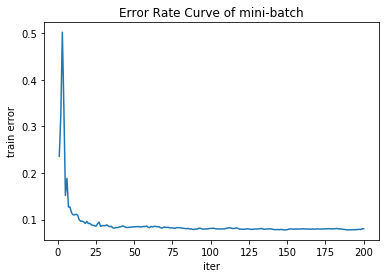

In [15]:
max_iter1 = 200
w1, error_rate_list1 = pegasos(X_train, y_train, 0.001, max_iter1, 100)
plt.plot(range(1, max_iter1 + 1),error_rate_list1)
plt.xlabel('iter')
plt.ylabel('train error')
plt.title('Error Rate Curve of mini-batch')

In [16]:
# PEGASOS Algorithm
def pegasos2(X_train, y_train, Lambda, T):
    w = np.zeros((1, feature))
    error_rate_list = list()
    for t in range(1, T+1):
        error_rate_list.append(err_rate(X_train, y_train, w))
        num = np.random.randint(100000)
        eta_t = 1/(Lambda*t)    
        if np.dot(y_train[num],(w*X_train[num].T))<= 0:        
            w = (1 - eta_t*Lambda)*w + eta_t*X_train[num]*y_train[num]
        else:
            w = (1 - eta_t*Lambda)*w

    return w, error_rate_list

Text(0.5, 1.0, 'Error Rate Curve')

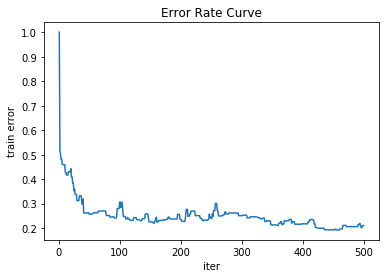

In [17]:
max_iter2 = 500
w2, error_rate_list2 = pegasos2(X_train, y_train, 0.001, max_iter2)
plt.plot(range(1, max_iter2 + 1),error_rate_list2)
plt.xlabel('iter')
plt.ylabel('train error')
plt.title('Error Rate Curve')

# Problem 3 AdaGrad

In [18]:
# Adagrad Algorithm
def AdaGrad(X_train, y_train, Lambda, T, sigma, minibatch_size):
    St = 0
    wt = np.zeros((1, feature))
    error_rate_list = list()
    for t in range(1, T+1):
        At_x = []
        At_y = []
        num = np.random.randint(100000, size = minibatch_size)
        for i in num:
            At_x.append(X_train[i])
            At_y.append(y_train[i])

        At_x_plus = []
        At_y_plus = []        

        for j in range(len(At_x)):            
            if At_y[j]*np.dot(At_x[j].toarray(),wt.T) < 1:

                At_x_plus.append(At_x[j])
                At_y_plus.append(At_y[j])

        temp = []
        for n in range(len(At_x_plus)):
            temp.append(np.dot(At_x_plus[n],At_y_plus[n]))

        eta = 1/(Lambda*t)
        grad = Lambda*wt - eta*(1/100000)*sum(temp)

        St = St + np.dot(grad,grad.T)

        delta_w = -(eta/(sigma + np.sqrt(St))) * grad

        wt = wt + delta_w
        error_rate_list.append(err_rate(X_train, y_train, wt))
    return wt, error_rate_list

Text(0.5, 1.0, 'Error Rate Curve of AdaGrad')

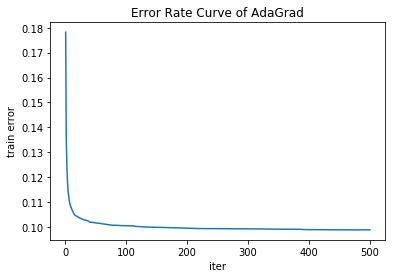

In [33]:
max_iter3 = 500
w3, error_rate_list3 = AdaGrad(X_train, y_train, 0.001, max_iter3, 1e-6, 1000)
plt.plot(range(1, max_iter3 + 1),error_rate_list3)
plt.xlabel('iter')
plt.ylabel('train error')
plt.title('Error Rate Curve of AdaGrad')

Text(0.5, 1.0, 'Error Rate Curve')

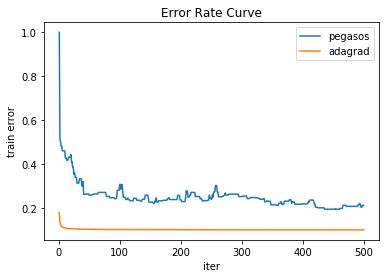

In [53]:
plt.plot(range(1, max_iter2 + 1),error_rate_list2)
plt.plot(range(1, max_iter3 + 1),error_rate_list3)
plt.xlabel('iter')
plt.ylabel('train error')
plt.legend(['pegasos', 'adagrad'])
plt.title('Error Rate Curve')

Text(0.5, 1.0, 'Error Rate Curve')

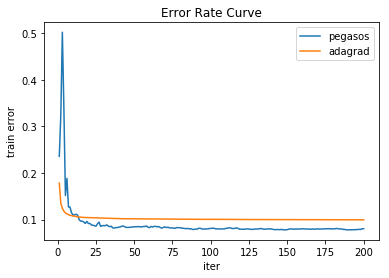

In [54]:
plt.plot(range(1, max_iter1 + 1),error_rate_list1)
plt.plot(range(1, max_iter1 + 1),error_rate_list3[0:200])
plt.xlabel('iter')
plt.ylabel('train error')
plt.legend(['pegasos', 'adagrad'])
plt.title('Error Rate Curve')

# Problem 4 Neural Nets

# (1)

In [20]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [35]:
def labelModifier(y):
    for i in range(len(y)):
        if y[i] == -1:
            y[i] = 0
    return y

In [36]:
Y_train = labelModifier(y_train)
Y_test = labelModifier(y_test)

In [37]:
scaler = StandardScaler(with_mean = False).fit(X_train)
X_train = scaler.transform(X_train)

In [38]:
def NeuralNet(n_hidden, layers):
    # Initialize the constructor
    model = Sequential()

    # Add an input layer 
    model.add(Dense(n_hidden, activation='relu', input_shape=(feature, )))
    
    for i in range(layers):
        #Add one hidden layer 
        model.add(Dense(n_hidden, activation='relu'))

    # Add an output layer 
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [44]:
model1 = NeuralNet(100, 1)
model2 = NeuralNet(100, 2)
model3 = NeuralNet(100, 3)

In [45]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model2.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model3.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])

In [46]:
train_result_1 = model1.fit(X_train, Y_train, epochs=5, batch_size=1000, verbose=1)
train_result_2 = model2.fit(X_train, Y_train, epochs=5, batch_size=1000, verbose=1)
train_result_3 = model3.fit(X_train, Y_train, epochs=5, batch_size=1000, verbose=1)

Epoch 1/5
100000/100000 [==============================] - 69s 690us/step - loss: 0.6019 - acc: 0.7046
Epoch 2/5
100000/100000 [==============================] - 69s 694us/step - loss: 0.3591 - acc: 0.8828
Epoch 3/5
100000/100000 [==============================] - 69s 693us/step - loss: 0.2272 - acc: 0.9276
Epoch 4/5
100000/100000 [==============================] - 70s 697us/step - loss: 0.1652 - acc: 0.9475
Epoch 5/5
100000/100000 [==============================] - 80s 796us/step - loss: 0.1307 - acc: 0.9592
Epoch 1/5
100000/100000 [==============================] - 82s 817us/step - loss: 0.6574 - acc: 0.6302
Epoch 2/5
100000/100000 [==============================] - 82s 815us/step - loss: 0.4863 - acc: 0.8252
Epoch 3/5
100000/100000 [==============================] - 82s 822us/step - loss: 0.2926 - acc: 0.9043
Epoch 4/5
100000/100000 [==============================] - 82s 823us/step - loss: 0.1902 - acc: 0.9372
Epoch 5/5
100000/100000 [==============================] - 83s 829us/step

Text(0, 0.5, 'train error')

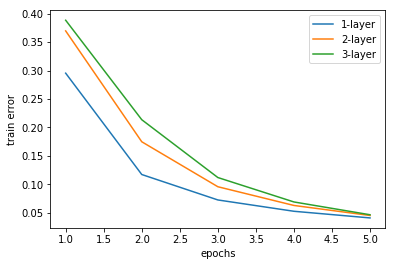

In [47]:
plt.plot([1,2,3,4,5], 1 - np.array(train_result_1.history['acc']))
plt.plot([1,2,3,4,5], 1 - np.array(train_result_2.history['acc']))
plt.plot([1,2,3,4,5], 1 - np.array(train_result_3.history['acc']))
plt.legend(['1-layer', '2-layer', '3-layer'])
plt.xlabel('epochs')
plt.ylabel('train error')

# (2)

In [48]:
def select_model(n_hiddens_selection, layers_selection):
    train_results = {}
    for i in n_hiddens_selection:
        for j in layers_selection:
            model = NeuralNet(i, j)
            model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
            train_result = model.fit(X_train, Y_train, epochs = 5, batch_size = 1000, verbose=1)
            train_results[(i, j)] = 1 - np.array(train_result.history['acc'])
            
    return train_results

In [49]:
train_results = select_model([25, 50, 100], [2, 4, 6])

Epoch 1/5
100000/100000 [==============================] - 64s 637us/step - loss: 0.6558 - acc: 0.6379
Epoch 2/5
100000/100000 [==============================] - 61s 611us/step - loss: 0.4475 - acc: 0.8361
Epoch 3/5
100000/100000 [==============================] - 59s 589us/step - loss: 0.2656 - acc: 0.9079
Epoch 4/5
100000/100000 [==============================] - 59s 588us/step - loss: 0.1829 - acc: 0.9384
Epoch 5/5
100000/100000 [==============================] - 58s 585us/step - loss: 0.1395 - acc: 0.9537
Epoch 1/5
100000/100000 [==============================] - 61s 606us/step - loss: 0.6816 - acc: 0.5625
Epoch 2/5
100000/100000 [==============================] - 64s 636us/step - loss: 0.6258 - acc: 0.6637
Epoch 3/5
100000/100000 [==============================] - 63s 625us/step - loss: 0.4840 - acc: 0.8210
Epoch 4/5
100000/100000 [==============================] - 61s 612us/step - loss: 0.2985 - acc: 0.9001
Epoch 5/5
100000/100000 [==============================] - 67s 669us/step

In [50]:
train_results

{(25, 2): array([0.36213, 0.16392, 0.09208, 0.06165, 0.04625]),
 (25, 4): array([0.43752, 0.33632, 0.17899, 0.09995, 0.06467]),
 (25, 6): array([0.49628, 0.43935, 0.39392, 0.28717, 0.18144]),
 (50, 2): array([0.32724, 0.13514, 0.07782, 0.05317, 0.03974]),
 (50, 4): array([0.44845, 0.37293, 0.22557, 0.11438, 0.06954]),
 (50, 6): array([0.46186, 0.45882, 0.43564, 0.2871 , 0.14373]),
 (100, 2): array([0.3525 , 0.15466, 0.08605, 0.0583 , 0.04241]),
 (100, 4): array([0.45978, 0.3871 , 0.2714 , 0.15678, 0.09231]),
 (100, 6): array([0.48169, 0.45013, 0.41079, 0.26186, 0.13749])}

In [52]:
# Dataframe, whose index represents different n hiddens, and columns different layers
result_df = pd.DataFrame(index = [25, 50, 100], columns = [2, 4, 6])
for i in result_df.index:
    for j in result_df.columns:
        result_df.loc[i, j] = train_results[(i, j)][-1]
        
result_df

,2,4,6
25,0.04625,0.06467,0.18144
50,0.03974,0.06954,0.14373
100,0.04241,0.09231,0.13749


Text(0.5, 1.0, 'train error of different networks')

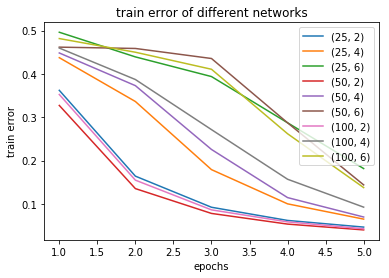

In [51]:
for key, value in train_results.items():
    plt.plot([1,2,3,4,5], value)
plt.legend(train_results.keys())
plt.xlabel('epochs')
plt.ylabel('train error')
plt.title('train error of different networks')

# Problem 5

In [28]:
# pegasos 
err_rate(X_test, y_test, w1.T)

0.08112700769717807

In [29]:
# pegasos 
err_rate(X_test, y_test, w2)

0.21994168202221986

In [34]:
# Adagrad
err_rate(X_test, y_test, w3)

0.09785722600629743

In [40]:
model = NeuralNet(50, 2)
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
train_result = model.fit(X_train, Y_train, epochs = 5, batch_size = 1000, verbose=1)

Epoch 1/5
100000/100000 [==============================] - 60s 598us/step - loss: 0.6525 - acc: 0.6449
Epoch 2/5
100000/100000 [==============================] - 59s 594us/step - loss: 0.4698 - acc: 0.8311
Epoch 3/5
100000/100000 [==============================] - 60s 600us/step - loss: 0.2786 - acc: 0.9047
Epoch 4/5
100000/100000 [==============================] - 60s 601us/step - loss: 0.1856 - acc: 0.9381
Epoch 5/5
100000/100000 [==============================] - 60s 603us/step - loss: 0.1385 - acc: 0.9546


In [42]:
scaler = StandardScaler(with_mean = False).fit(X_test)
X_test = scaler.transform(X_test)

In [43]:
y_pred = model.predict(X_test,verbose = 1)
score = model.evaluate(X_test, Y_test,verbose = 1)
print(score)

704414/704414 [==============================] - 585s 831us/step
[0.24675072574596557, 0.9088859676273305]
